In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/install-future-program-ankara-hackathon/sample_submission.csv
/kaggle/input/install-future-program-ankara-hackathon/train.csv
/kaggle/input/install-future-program-ankara-hackathon/test.csv


In [45]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import optuna

In [5]:
train = pd.read_csv("/kaggle/input/install-future-program-ankara-hackathon/train.csv")
test = pd.read_csv("/kaggle/input/install-future-program-ankara-hackathon/test.csv")

In [6]:
train["DATETIME"] = pd.to_datetime(train["DATETIME"])
test["DATETIME"] = pd.to_datetime(test["DATETIME"])

In [7]:
def create_features(df):
    df = df.copy()
    df["month"] = df["DATETIME"].dt.month
    df["day"] = df["DATETIME"].dt.day
    df["hour"] = df["DATETIME"].dt.hour
    df["minute"] = df["DATETIME"].dt.minute

    return df

In [8]:
def outlier_thresholds(df, col_name, q1=0.25, q3=0.75):
    quartile1 = df[col_name].quantile(q1)
    quartile3 = df[col_name].quantile(q3)
    iqr = quartile3 - quartile1
    up = quartile3 + 1.5 * iqr
    low = quartile1 - 1.5 * iqr
    return low, up

In [9]:
def check_outlier(df, col_name):
    low, up = outlier_thresholds(df, col_name)
    return True if df[(df[col_name] > up) | (df[col_name] < low)].any(axis = None) else False

In [10]:
def replace_with_thresholds(df, veriable):
    df = df.copy()
    low, up = outlier_thresholds(df, veriable)
    df.loc[(df[veriable] < low), veriable] = low
    df.loc[(df[veriable] > up), veriable] = up
    return df

In [11]:
def one_hot_encoder(df, categorical_cols, drop_first=True):
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=drop_first)
    return df

In [12]:
def preproccesing_df(df):
    df = df.copy()
    res_df = pd.DataFrame()
    for i in df["SERVER"].unique():
        temp_df = df[df["SERVER"] == i]
        temp_df = temp_df.groupby("DATETIME").agg({"CPULOAD":"mean"}).reset_index()
        temp_df["SERVER"] = i
        res_df = pd.concat([res_df, temp_df])
    
    res_df = create_features(res_df)
    return res_df

In [13]:
def prep_test(df):
    test_301 = test[test["SERVER"] == "CIHAZ_301"]
    test_305 = test[test["SERVER"] == "CIHAZ_305"]
    test_301 = test_301.groupby("DATETIME").agg({"SERVER":"count"}).reset_index()
    test_301["SERVER"] = "CIHAZ_301"
    test_305 = test_305.groupby("DATETIME").agg({"SERVER":"count"}).reset_index()
    test_305["SERVER"] = "CIHAZ_305"
    df = pd.concat([test_301, test_305])
    df = create_features(df)
    return df

In [14]:
def is_weekend(ds):
    date = pd.to_datetime(ds)
    return date.day_name in ('Saturday', 'Sunday')

def is_night(ds):
    date = pd.to_datetime(ds)
    return (date.hour >= 0) & (date.hour <= 5)

def is_morning(ds):
    date = pd.to_datetime(ds)
    return (date.hour >= 6) & (date.hour <= 11)

def is_afternoon(ds):
    date = pd.to_datetime(ds)
    return (date.hour >= 12) & (date.hour <= 17)

def is_evening(ds):
    date = pd.to_datetime(ds)
    return (date.hour >= 18) & (date.hour <= 23)

In [15]:
def add_is(df):
    df = df.copy()
    df['is_weekend'] = df['DATETIME'].apply(is_weekend)
    df['is_night'] = df['DATETIME'].apply(is_night)
    df['is_morning'] = df['DATETIME'].apply(is_morning)
    df['is_afternoon'] = df['DATETIME'].apply(is_afternoon)
    df['is_evening'] = df['DATETIME'].apply(is_evening)
    return df

In [16]:
def check_df(df):
    print("SHAPE\n", df.shape)
    print(20 * "#")
    print("COLUMNS\n", df.columns)
    print(20 * "#")
    print("HEAD\n", df.head())
    print(20 * "#")
    print("TAIL\n", df.tail())
    print(20 * "#")
    print("INFO\n", df.info())
    print(20 * "#")
    print("DESCRIBE\n", df.describe().T)
    print(20 * "#")
    print("NULL\n", df.isnull().sum())
    print(20 * "#")
    print("DUPLICATED\n", df.duplicated().sum())

In [17]:
prep_train = preproccesing_df(train)

In [18]:
check_df(prep_train)

SHAPE
 (13029, 7)
####################
COLUMNS
 Index(['DATETIME', 'CPULOAD', 'SERVER', 'month', 'day', 'hour', 'minute'], dtype='object')
####################
HEAD
                    DATETIME   CPULOAD     SERVER  month  day  hour  minute
0 2020-03-24 00:00:00+03:00  4.425000  CIHAZ_301      3   24     0       0
1 2020-03-24 00:15:00+03:00  4.427500  CIHAZ_301      3   24     0      15
2 2020-03-24 00:30:00+03:00  3.910417  CIHAZ_301      3   24     0      30
3 2020-03-24 00:45:00+03:00  3.633750  CIHAZ_301      3   24     0      45
4 2020-03-24 01:00:00+03:00  3.575000  CIHAZ_301      3   24     1       0
####################
TAIL
                       DATETIME    CPULOAD     SERVER  month  day  hour  minute
6509 2020-05-30 22:45:00+03:00  13.932917  CIHAZ_305      5   30    22      45
6510 2020-05-30 23:00:00+03:00  10.920833  CIHAZ_305      5   30    23       0
6511 2020-05-30 23:15:00+03:00  10.177917  CIHAZ_305      5   30    23      15
6512 2020-05-30 23:30:00+03:00   9.696667

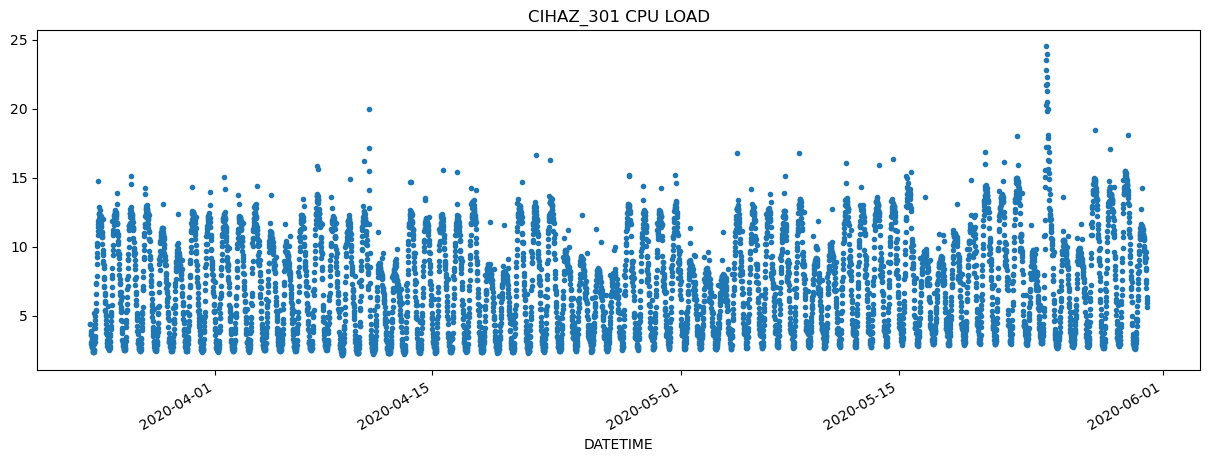

In [19]:
prep_train[prep_train["SERVER"] == "CIHAZ_301"].set_index("DATETIME")["CPULOAD"].plot(
                                                     style='.',
                                                     figsize=(15, 5),
                                                     title='CIHAZ_301 CPU LOAD'
                                                    );

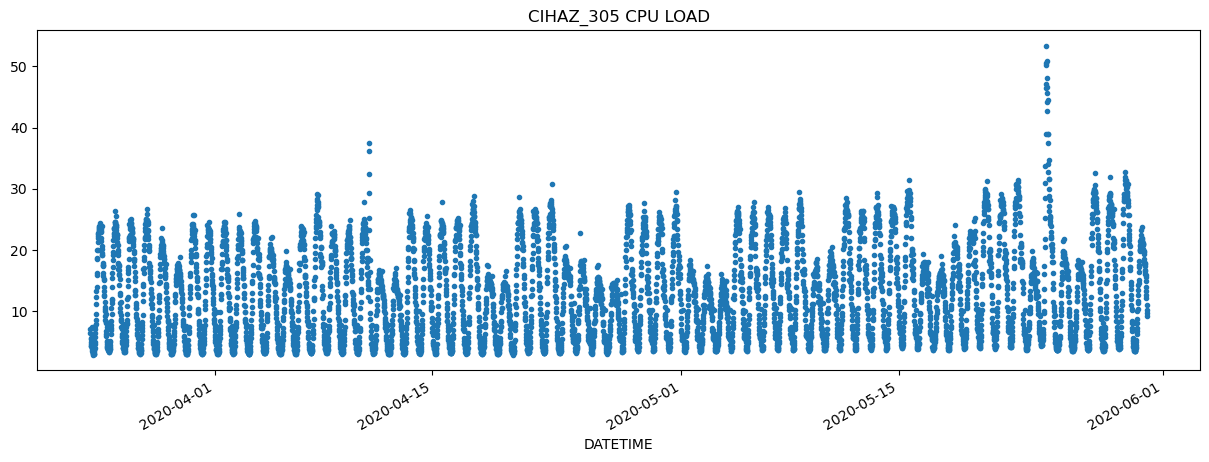

In [20]:
prep_train[prep_train["SERVER"] == "CIHAZ_305"].set_index("DATETIME")["CPULOAD"].plot(
                                                     style='.',
                                                     figsize=(15, 5),
                                                     title='CIHAZ_305 CPU LOAD'
                                                    );

In [21]:
print("Cihaz 301 Outlier:",
      check_outlier(prep_train[prep_train["SERVER"] == "CIHAZ_301"], "CPULOAD"))

Cihaz 301 Outlier: True


In [22]:
print("Cihaz 305 Outlier:",
      check_outlier(prep_train[prep_train["SERVER"] == "CIHAZ_305"], "CPULOAD"))

Cihaz 305 Outlier: True


In [23]:
prep_train[prep_train["SERVER"] == "CIHAZ_301"] = replace_with_thresholds(prep_train[prep_train["SERVER"] == "CIHAZ_301"], "CPULOAD")
prep_train[prep_train["SERVER"] == "CIHAZ_305"] = replace_with_thresholds(prep_train[prep_train["SERVER"] == "CIHAZ_305"], "CPULOAD")

In [24]:
print("Cihaz 305 Outlier:",
      check_outlier(prep_train[prep_train["SERVER"] == "CIHAZ_305"], "CPULOAD"))

Cihaz 305 Outlier: False


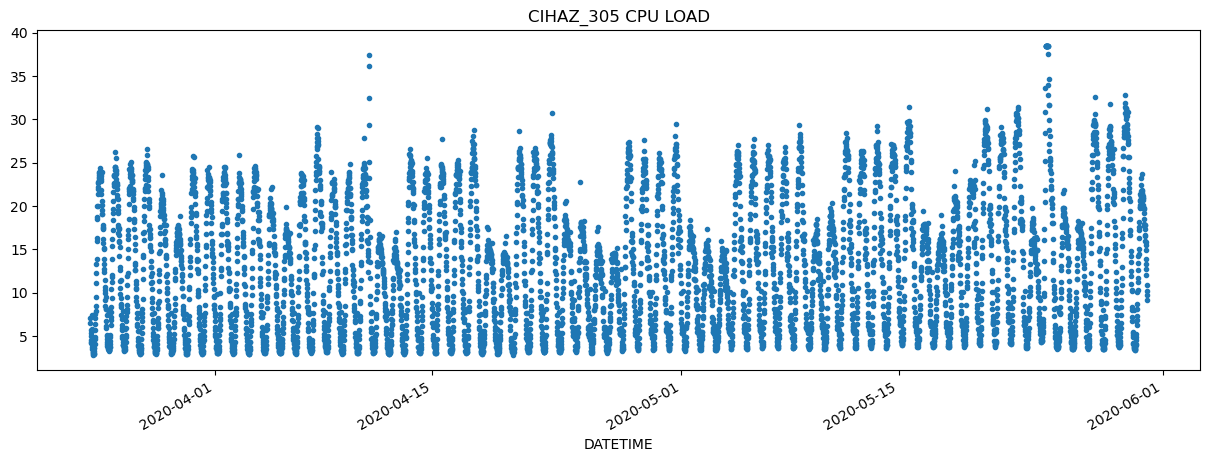

In [25]:
prep_train[prep_train["SERVER"] == "CIHAZ_305"].set_index("DATETIME")["CPULOAD"].plot(
                                                     style='.',
                                                     figsize=(15, 5),
                                                     title='CIHAZ_305 CPU LOAD'
                                                    );

In [26]:
prep_train = add_is(prep_train)

In [27]:
prep_train = one_hot_encoder(prep_train, ["SERVER", "is_weekend", "is_night", "is_morning", "is_afternoon", "is_evening"])

In [28]:
X = prep_train.drop(["DATETIME", "CPULOAD"], axis=1)
y = prep_train["CPULOAD"]

In [37]:
train_size = int(X.shape[0] * 0.8)
X_train = X.iloc[:train_size]
X_val = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_val = y.iloc[train_size:]

In [38]:
preped_test = prep_test(test)
preped_test = add_is(preped_test)
preped_test = one_hot_encoder(preped_test, ["SERVER","is_weekend", "is_night", "is_morning", "is_afternoon", "is_evening"])

In [39]:
model = CatBoostRegressor()
model.fit(X_train, 
          y_train, 
          verbose=False, 
          cat_features=["month", "day", "hour", "minute"], 
          eval_set=(X_val, y_val)
         )

In [40]:
pred = model.predict(preped_test.drop(["DATETIME"], axis=1))

In [41]:
preped_test["CPULOAD"] = pred

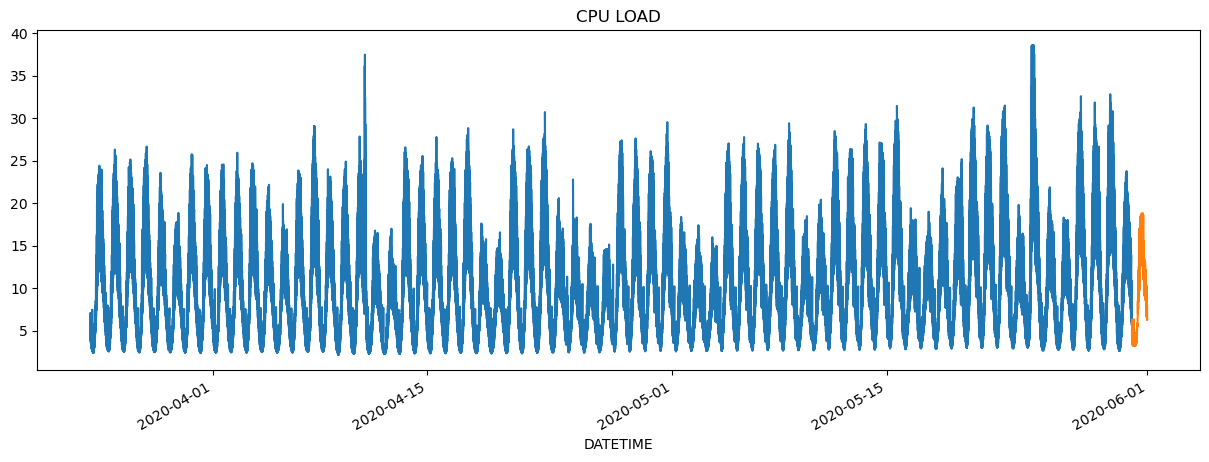

In [42]:
prep_train.set_index("DATETIME")["CPULOAD"].plot(figsize=(15, 5), title="CPU LOAD", style="-")
preped_test.set_index("DATETIME")["CPULOAD"].plot(figsize=(15, 5), title="CPU LOAD", style="-");

## Hyper-Parameter Optimization

In [46]:
def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train, cat_features=["month", "day", "hour", "minute"])
    predictions = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    return rmse

In [47]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2023-07-08 11:12:41,990] A new study created in memory with name: no-name-a22fd82f-c469-46f5-a3ae-7576e1f0f505
[I 2023-07-08 11:12:43,601] Trial 0 finished with value: 5.370630574983025 and parameters: {'learning_rate': 0.007675495200929731, 'depth': 1, 'subsample': 0.6833085621332873, 'colsample_bylevel': 0.4010072570735479, 'min_data_in_leaf': 14}. Best is trial 0 with value: 5.370630574983025.
[I 2023-07-08 11:12:56,026] Trial 1 finished with value: 5.205918747502149 and parameters: {'learning_rate': 0.019024165390361204, 'depth': 10, 'subsample': 0.09963639033020452, 'colsample_bylevel': 0.829816825528812, 'min_data_in_leaf': 4}. Best is trial 1 with value: 5.205918747502149.
[I 2023-07-08 11:13:07,666] Trial 2 finished with value: 5.157238660942162 and parameters: {'learning_rate': 0.03013039467821317, 'depth': 10, 'subsample': 0.35697427537129617, 'colsample_bylevel': 0.4787722167897573, 'min_data_in_leaf': 72}. Best is trial 2 with value: 5.157238660942162.
[I 2023-07-08 11:1

In [48]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.09703473650316832, 'depth': 4, 'subsample': 0.9344617226310771, 'colsample_bylevel': 0.6544042000469947, 'min_data_in_leaf': 31}
Best RMSE: 3.725496781654316


In [64]:
model = CatBoostRegressor(**study.best_params)

In [66]:
model.fit(X_train, y_train, 
          verbose=False, 
          cat_features=["month", "day", "hour", "minute"],
          eval_set = (X_val, y_val)
         )

In [67]:
preped_test = prep_test(test)
preped_test = add_is(preped_test)
preped_test = one_hot_encoder(preped_test, ["SERVER","is_weekend", "is_night", "is_morning", "is_afternoon", "is_evening"])

In [68]:
pred = model.predict(preped_test.drop(["DATETIME"], axis=1))

In [69]:
preped_test["CPULOAD"] = pred

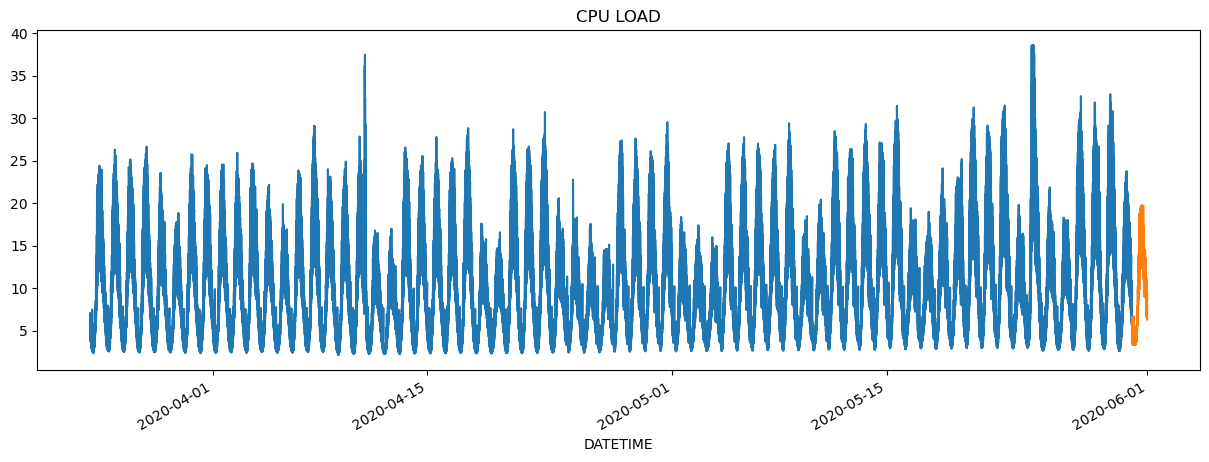

In [70]:
prep_train.set_index("DATETIME")["CPULOAD"].plot(figsize=(15, 5), title="CPU LOAD", style="-")
preped_test.set_index("DATETIME")["CPULOAD"].plot(figsize=(15, 5), title="CPU LOAD", style="-");

In [71]:
submission = pd.read_csv("/kaggle/input/install-future-program-ankara-hackathon/sample_submission.csv")

In [72]:
preped_test

,DATETIME,month,day,hour,minute,SERVER_CIHAZ_305,is_night_True,is_morning_True,is_afternoon_True,is_evening_True,CPULOAD
0,2020-05-31 00:00:00+03:00,5,31,0,0,0,1,0,0,0,4.512271
1,2020-05-31 00:15:00+03:00,5,31,0,15,0,1,0,0,0,3.513949
2,2020-05-31 00:30:00+03:00,5,31,0,30,0,1,0,0,0,3.567792
3,2020-05-31 00:45:00+03:00,5,31,0,45,0,1,0,0,0,3.567792
4,2020-05-31 01:00:00+03:00,5,31,1,0,0,1,0,0,0,3.383244
...,...,...,...,...,...,...,...,...,...,...,...
91,2020-05-31 22:45:00+03:00,5,31,22,45,1,0,0,0,1,10.943332
92,2020-05-31 23:00:00+03:00,5,31,23,0,1,0,0,0,1,9.597490
93,2020-05-31 23:15:00+03:00,5,31,23,15,1,0,0,0,1,9.542450
94,2020-05-31 23:30:00+03:00,5,31,23,30,1,0,0,0,1,9.473601


In [73]:
submission["CPULOAD"] = preped_test["CPULOAD"].values

In [74]:
submission.to_csv("submission.csv", index=False)